# Logistic regression

Predict house pricing of a given Bostion suburb during the '70s

In [91]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.datasets import boston_housing

In [92]:
boston_housing

<module 'tensorflow.keras.datasets.boston_housing' from 'C:\\Users\\90545\\AppData\\Roaming\\Python\\Python38\\site-packages\\tensorflow\\keras\\datasets\\boston_housing\\__init__.py'>

### Datasets

Train data are features describing the suburb at the time, like crime rate, local property taxrate etc. Targets are the mediam values of owner-occupied homes, in thousands of dollars

In [93]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [94]:
train_data

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

In [95]:
train_data.shape

(404, 13)

In [96]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

train_targets

### Normalizing data

Normalize data to avoid feeding the model with values having different ranges. Perform feature-wise normalization. Subtract the mean of the feature nd divide by the standard deviation.

**NB**: test data is alao normalized with mean and standard deviation calculated on training data

In [97]:
from sklearn.preprocessing import StandardScaler

In [98]:
sc = StandardScaler()

In [99]:
train_data = sc.fit_transform(train_data)
test_data = sc.fit_transform(test_data)

In [100]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

In [101]:
# mean = train_data.mean(axis = 0)
# train_data -= mean

# std = train_data.std(axis = 0)
# train_data /= std

# test_data -= mean
# test_data /= std

In [102]:
# train_data[0]

### Building the model

This will be a scalar regression, so the network will end with a single unit and no activation. Being the layer purely linear, the network is free to learn values in any range.

**Loss:** mse, _mean squared error_, which is the square of the difference between predictions and targets.

**Other metrics:** _mean absolute error_ (mae), which is the absolute value of the difference between predictions and targets

In [103]:
def model_build():
    
    model = models.Sequential()
    model.add(layers.Dense(64, activation = "relu", input_shape = (train_data.shape[1], )))
    model.add(layers.Dense(64, activation = "relu"))
    model.add(layers.Dense(1))
              
    model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
              
    return model

### Validation

The dataset does not have enough datapoints to have a reliable validation set that will not suffer of high variance depending on which portion of data will be chosen. So, we will use the K-fold cross-validation method for this model.

#### K-Fold Cross Validation Method

In [110]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

In [111]:
for i in range(k):
    
    print("Processing Fold: {}".format(i))
    
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[: i * num_val_samples], 
                                        train_data[(i + 1) * num_val_samples:]], 
                                       axis = 0)
    
    partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], 
                                            train_targets[(i + 1) * num_val_samples:]], 
                                            axis = 0)
    
    model = model_build()
    history = model.fit(partial_train_data, 
                       partial_train_targets, 
                       epochs = num_epochs, 
                       verbose = 0, 
                       batch_size = 1, 
                       validation_data = (val_data, val_targets))
    
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing Fold: 0
Processing Fold: 1
Processing Fold: 2
Processing Fold: 3


In [124]:
average_mae_history = [
    np.mean([hist[i] for hist in all_mae_histories]) for i in range(num_epochs)
]

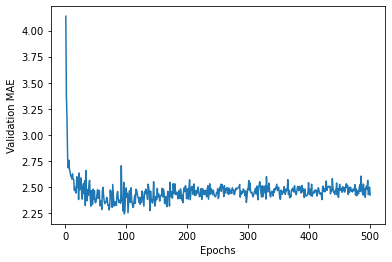

In [125]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Despite presenting values in different scale, we can see that the MAE stops decreasing and increases again, showing a possible overfitting. In order to determine more exactly when it happens, we have to make the curve smoother:

- omit the first 10 data points that are on a different scale;
- replace each point with an exponential moving average of the previous points

In [126]:
def smooth_curve(points, factor = 0.9):
    
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points = [-1]
            smoothed_points.append(previous * factor + point * (factor + 1))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

In [130]:
smooth_mae_history = smooth_curve(points = all_mae_histories[10:])

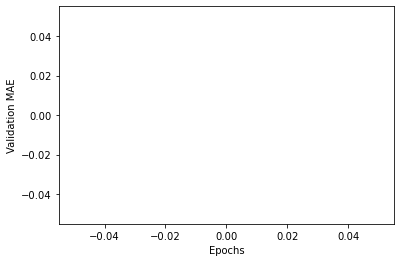

In [131]:
plt.clf()
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [132]:
model = model_build()

In [134]:
model.fit(train_data, 
         train_targets, 
         epochs = 55, 
         batch_size = 16, 
         validation_data = (test_data, test_targets))

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/55
26/26 [==============================] - 3s 17ms/step - loss: 575.4129 - mae: 22.1299 - val_loss: 521.3309 - val_mae: 20.7414
Epoch 2/55
26/26 [==============================] - 0s 6ms/step - loss: 484.7196 - mae: 19.6703 - val_loss: 371.6900 - val_mae: 17.0516
Epoch 3/55
26/26 [==============================] - 0s 6ms/step - loss: 298.1151 - mae: 14.8713 - val_loss: 175.1537 - val_mae: 11.4792
Epoch 4/55
26/26 [==============================] - 0s 7ms/step - loss: 132.7174 - mae: 9.0983 - val_loss: 68.0379 - val_mae: 6.6687
Epoch 5/55
26/26 [==============================] - 0s 6ms/step - loss: 45.8639 - mae: 5.1209 - val_loss: 41.6475 - val_mae: 5.0679
Epoch 6/55
26/26 [==============================] - 0s 6ms/step - loss: 43.2609 - mae: 4.6894 - val_loss: 30.5649 - val_mae: 4.3717
Epoch 7/55
26/26 [==============================] - 0s 11ms/step - loss: 30.6245 - mae: 3.8120 - val_loss: 25.8204 - val_mae: 3.9817
Epoch 8/55
26/26 [==============================] - 0s 8ms/st

In [135]:
print("test_mse_score: {}".format(test_mse_score))

test_mse_score: 19.021556854248047


In [138]:
print("test_mae_score: {}".format(test_mae_score))

test_mae_score: 2.756114959716797


The results show that we are still off by about `$2750`